## Allgemeines

Eine allgemeine Beschreibung der Laboraufgaben inklusive des Vorgehens, den Bewertungsrichtlinien und der Abgabe finden Sie  <a href="ML-allgemein.ipynb">hier</a>

## Datenquelle


* Laden Sie ihre Daten von http://141.72.190.207/ml_lab/G_fragen herunter
    * Die Daten sind geschützt.
        * Sie müssen evtl. in einem Netzwerk der DHBW (z.B. WLAN, VPN, ...) angemeldet sein.
        * Sie können sich auf der Webseite mit dem Benutzernamen dhbw und dem Zugangsnamen ml_2021 anmelden.
* Die Daten sind in einem anwendungsspezifischen Format gespeichert.
    * Sie finden evtl. Informationen über die Daten in einer "README" Datei.
    * Finden Sie keine solche Datei sind die Daten selbst erklärend.

# Aufgabe

Die Datensammlung enthält Fragen aus einem Forum. Es sind Paare aus Fragen gleichen Inhalts geboten.

Erstellen Sie ein tiefes Neuronales Netzwerk, dass dem Nutzer schon bei der Eingabe einer neuen Frage gleich ähnliche Fragen anbietet.
* Je mehr Text der Benutzer eingibt, desto präziser sollen die ähnlichen Fragen sein!

# Lösung
## Trainingsumgebung
Plattform:
- CPU: AMD Ryzen 5 1500X
- RAM: 16GB DDR4
- GPU: Nvidia Geforce RTX 3060ti
- OS: Linux, Kernel 5.16
- Python: 3.9.10
- Tensorflow: 2.8.0
- Keras: 2.8
- Kerastuners: 1.1.0
## Betrachtung des Datensatzes
Der Datensatz beinhaltet neben den README-Dateien 3 CSV-Dateien.
Enthalten sind die Dateien `training.csv`, `test.csv` und `sample_submission.csv`

### Trainings-Datensatz
Der Trainingsdatensatz ist in der Datei 'training.csv' enthalten.
Der Datensatz enthält insgesamt 5 Attribute pro Eintrag.
Eine allgemeine 'id', eine 'qid1' & 'qid2' für die jeweilige Frage.
Schlussendlich folgen die beiden Fragen sowie die Spalte 'is_duplicate', bei welcher zwei Fragen mit dem gleichen Sinn mit dem Label 1 versehen sind.

#### Aussortieren nicht benötigter Parameter

Die Attribute 'question1', 'question2' und 'is_duplicate' werden auf jedenfall benötigt, da in dieser die Fragen sowie das Klassifizierungslabel enthalten sind.

Im zu trainierenden Modell soll rein der textliche Inhalt der Fragen von Bedeutung sein. Aus diesem Grund werden beim Einlesen der Daten die Attribute 'id', 'qid1' & 'qid2' nicht mit geladen.

#### Vorverarbeitung der Daten
Im geladenen Dataframe werden die Einträge entfernt, welche in einer der Attribute einen NaN-Value besitzen. Dies ist nötig, da aus diesen Einträgen keinen sinnvollen Rückschlüsse gezogen werden können.

In [1]:
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Multiply, Flatten, Dropout, Dense, LSTM, SimpleRNN, Bidirectional, GRU
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

start_complete = time.time()
plt.rcParams["figure.figsize"] = 15,15
tf.random.set_seed(35)

df_train = pd.read_csv(
    "./fragen/train.csv",
    usecols = ['question1', 'question2', 'is_duplicate'],
    encoding = 'utf-8'
)

df_train.dropna(inplace=True)
df_train.head()

,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


Damit der Text präziser verarbeitet werden kann, werden außerdem alle Buchstaben in lowercase umgewandelt

In [2]:
df_train = df_train.applymap(lambda s: s.lower() if type(s) == str else s)

### Visualisieren der Trainingsdaten
#### Verteilung der Labels in den Trainingsdaten

Im folgenden wird die Verteilung der Labels in den Trainingsdaten mit Hilfe eines Balkendiagrammes visualisiert.

Text(0.5, 1.0, 'Number of elements found in dataset')

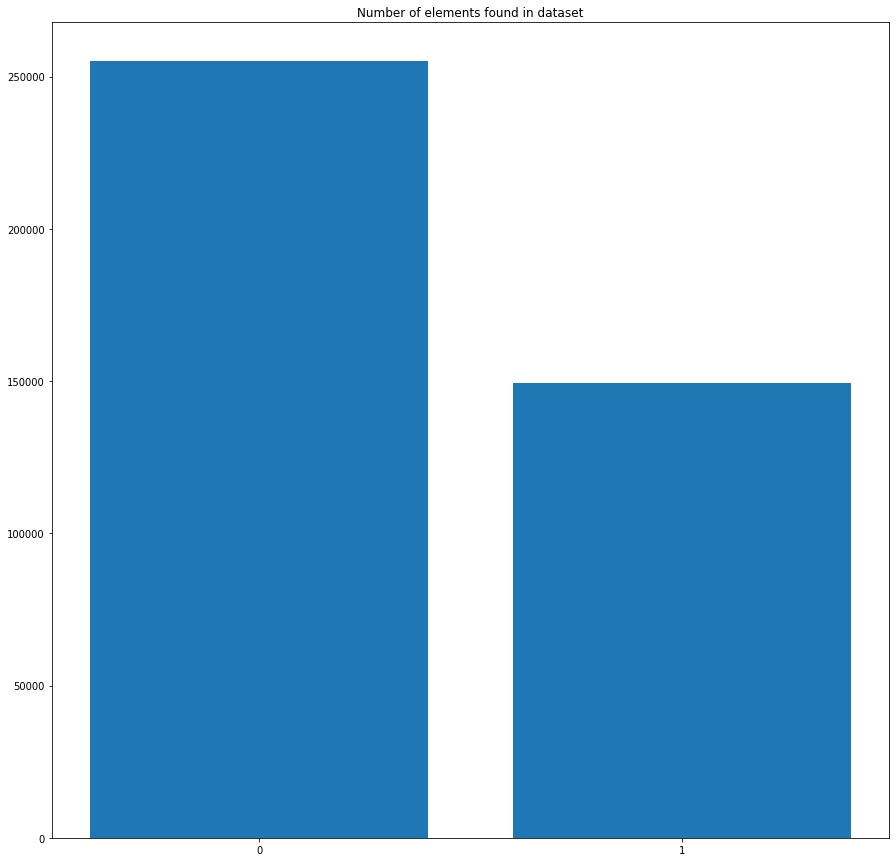

In [3]:
fig, ax = plt.subplots()
label_dist = df_train.is_duplicate.value_counts()

ax.bar([0,1],label_dist)
ax.set_xticks([0,1], labels=[0,1])
ax.set_title('Number of elements found in dataset')

In [4]:
label_dist[0] - label_dist[1]

105761

Es lässt sich beobachten, das circa 5/8 der Fragenpaare mit dem Label 0, also sinnlich nicht verwandt, versehen sind. Dies kann bei dem trainierten Model dazu führen, dass das Model zuverlässiger bei der Erkennung von nicht gleichen Fragen als bei gleichen Fragen ist.

#### Anzahl der Duplikate

In [5]:
df_train.duplicated(keep='first').sum()

341

#### Visualisierung der Häufigkeit der Wörter mit Hilfe einer Wordcloud

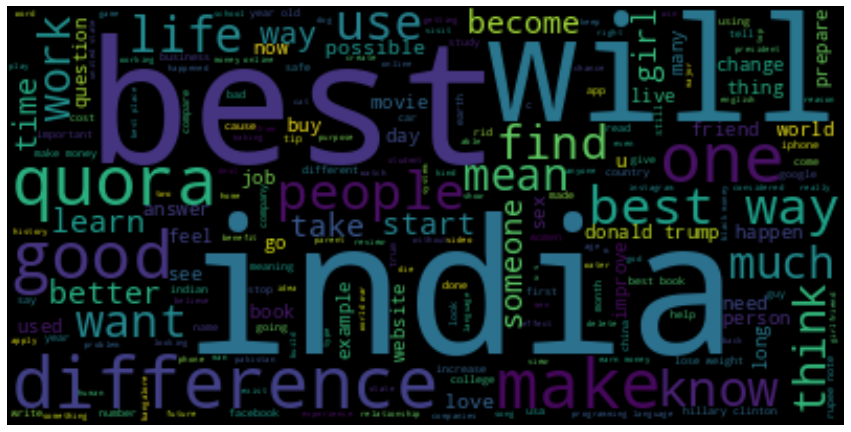

In [6]:
allQuestions = ' '.join(np.concatenate((df_train.question1, df_train.question2)))
wordcloud = WordCloud().generate(allQuestions)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Wie sich aus der Wordcloud auslesen lässt, kommen die Wörter 'india', 'will' und 'best' am häufigsten vor.
Daraus lässt sich schließen, das bei Fragen, welche diese Wörter beinhalten, unter Umständen schlechtere Vorhersagen getroffen werden können.

## Einlesen der Testdaten
Der Testdatensatz besteht aus zwei Dateien.
In der Datei `test.csv` befinden sich Fragenpaarungen, bestehend aus `question1` und `question2`.
Zuätzlich ist jede Fragenpaarung mit einer eindeutigen ID versehen, gekennzeichnet durch `test_id`.
Es werden analog zum Trainingsdatensatz Einträge mit einem NaN-Value entfernt, sowie alle Strings auf lowercase gesetzt.


In [7]:
df_test = pd.read_csv(
    "./fragen/test.csv",
    usecols= ['test_id', 'question1', 'question2'],
    encoding='utf-8'
)
#u_test, c_test = np.unique(test_data_raw.test_id, return_counts=True)
#if len(u_test[c_test > 1]) == 0:
#    print("test_id is unique")

df_test = df_test.applymap(lambda s: s.lower() if type(s) == str else s)
df_test.dropna(inplace=True)
df_test.head()

/tmp/ipykernel_5814/73418358.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test = pd.read_csv(


,test_id,question1,question2
0,0,how does the surface pro himself 4 compare wit...,why did microsoft choose core m3 and not core ...
1,1,should i have a hair transplant at age 24? how...,how much cost does hair transplant require?
2,2,what but is the best way to send money from ch...,what you send money to china?
3,3,which food not emulsifiers?,what foods fibre?
4,4,"how ""aberystwyth"" start reading?",how their can i start reading?


Zusätzlich zur Datei `test.csv`, gibt es eine Datei `sample_submission.csv`.
Diese enthält zwei Attribute pro Eintrag.
Die Spalte `test_id` ist eine Zuordnung zur entsprechenden Fragenpaarung aus `test.csv`.
Die Spalte `is_duplicate` besitzt die selbe Funktionalität wie die entsprechende Spalte aus dem Trainingsdatensatz.

In [8]:
df_submission = pd.read_csv(
    "./fragen/sample_submission.csv",
    usecols = ['test_id', 'is_duplicate']
)

df_submission.dropna(inplace=True)
df_submission.head()

,test_id,is_duplicate
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


Im folgenden wird eine Betrachtung der Verteilung der Labels aus der Spalte `is_duplicate` durchgeführt.

In [9]:
df_submission.is_duplicate.value_counts()

1    2345796
Name: is_duplicate, dtype: int64

Es ergibt sich, dass sämtliche Fragepaarung, zumindest laut der Datei `sample_submission.csv`, das Label 1 besitzen.
Dies ist in dem Sinne recht problematisch, da dadurch die Erkennung einer falschen Vorhersage nicht überprüft wird.

### Zusammenführen der beiden Dataframes
Im folgenden Code-Abschnitt werden die gewonnene Dataframes aus den beiden Dateien gemerged.
Der Merge erfolgt dabei anhand des Attributs `test_id`.

In [10]:
df_test_merged = df_test.merge(df_submission, left_on="test_id", right_on="test_id")

df_test_merged.dropna(inplace=True)
df_test_merged.drop_duplicates(inplace=True)
df_test_merged.head()

,test_id,question1,question2,is_duplicate
0,0,how does the surface pro himself 4 compare wit...,why did microsoft choose core m3 and not core ...,1
1,1,should i have a hair transplant at age 24? how...,how much cost does hair transplant require?,1
2,2,what but is the best way to send money from ch...,what you send money to china?,1
3,3,which food not emulsifiers?,what foods fibre?,1
4,4,"how ""aberystwyth"" start reading?",how their can i start reading?,1


Anschließend wird aus dem gemergten Dataframe die Spalte `is_duplicate` entfernt und in einer eigenen Variable abgespeichert.

In [11]:
target_test = df_test_merged.pop('is_duplicate')

## Aufteilung der Trainingsdaten in Trainings- und Validierungsdaten
Vom Trainingsdatensatz wird die Spalte 'is_duplicate' abgespaltet.
Der Trainingsdatensatz wird in Trainings- und Validierungsdaten aufgeteilt.
20% des Trainingsdatensatzes werden als Validierungsdatensatz benutzt.
Für ein reproduzierbares Ergebnis wurden bei der Aufteilung des Datensatzes ein festgelegter Seed verwendet.

In [12]:
target = df_train.pop('is_duplicate')

xTrain, xValid, yTrain, yValid = train_test_split(df_train, target, test_size=0.2, random_state=35)
xTrain.head()

,question1,question2
283108,which are the best german universities for an ...,which are the best german universities for an ...
73636,i like being merchant navy?,are astronauts allowed to masturbate in space?
46418,what is the legal definition of a human being?...,what do men think about menstrual cycle?
11449,how can i handle having personal issues with m...,how do i take things my partner says less pers...
283432,"how cold can the gobi desert get, and how do i...","how cold can the gobi desert get, and how do i..."


## Kodierung  und Anpassung der Form der Fragen
Damit alle Fragen das gleiche Format besitzen, muss eine einheitliche Länge gefunden werden.
Positionen, welche nicht durch die Interger-Werte der Wörter des vorherigen Stringes gefüllt wurden, werden mit dem Wert 0 gefüllt.

Es wurde sich für eine maximale Fragenlänge von 50 Wörtern entschieden, da dadurch nur 372 Einträge entfernt werden müssen, was weniger als 1% aller Fragen entspricht.

In [13]:
lengthQ1 = df_train.question1.str.split("\\s+")
lengthQ2 = df_train.question1.str.split("\\s+")
countLengthQ1 = lengthQ1.str.len().gt(36).value_counts()[True]
countLengthQ2 = lengthQ2.str.len().gt(36).value_counts()[True]
print(f"Anzahl der Fragen mit einer Länge von über 50 Wörtern: {countLengthQ1 + countLengthQ2}")

Anzahl der Fragen mit einer Länge von über 50 Wörtern: 2278


In [14]:
maxLengthQuestion = 36
df_train = df_train[df_train.question1.str.split("\\s+").str.len().le(maxLengthQuestion)]
df_train = df_train[df_train.question2.str.split("\\s+").str.len().le(maxLengthQuestion)]

Die Fragen der gesplitteten Datensätzen werden mittels des erstellten Tokenizer kodiert, sprich der String wird zu einem Array aus Integer umgewandelt.

In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(df_train.question1.values) + list(df_train.question2.values))


Es wird der Trainingsdaten, der Validierungsdatensatz und auch der Testdatensatz codiert.
Dies ist nötig, damit das Modell später die standardisierte Eingabe akzeptiert.
Bei der Evaluierung von Benutzer-Fragen muss eine Codierung dieser ebenfalls erfolgen.

In [16]:
def tokenizeQuestions(df_questions):
    tokenized_questions = tokenizer.texts_to_sequences(df_questions)
    return pad_sequences(tokenized_questions, maxlen = maxLengthQuestion, padding = 'post')

In [17]:
q1_train = tokenizeQuestions(xTrain.question1)
q2_train = tokenizeQuestions(xTrain.question2)

q1_valid = tokenizeQuestions(xValid.question1)
q2_valid = tokenizeQuestions(xValid.question2)

q1_test = tokenizeQuestions(df_test_merged.question1)
q2_test = tokenizeQuestions(df_test_merged.question2)

In [18]:
word_index = tokenizer.word_index

#### Erstellung eines Dictionaries, welche später für das Finden von ähnlichen Fragen verwendet wird
Es wird ein Sammlung aller Fragen aus dem Trainingsdatensatz erstellt.
Dabei werden Dupliakte aussortiert, sodass jede Frage nur einmal vorhanden ist.

Diese Sammlung kann anschließend im späteren Verlauf zum Finden von ähnlichen Fragen verwendet werden.

In [19]:
completeQuestionsDict = np.unique(np.concatenate((q1_train, q2_train, q1_valid, q2_valid)), axis=0)

## Erstellung des Modelles
### Entscheidung für die Form des Modelles
Vor der Erstellung des Modelles musste sich zunächst für die grundlegend Form des Modelles entschieden werden.
#### Seq2Seq-Model
Als erste Möglichkeit bestand die Erstellung eines sogenannten "Sequence to sequence"-, kurz "seq2seq"-Model.
Zur Vorbereitung wäre zunächst nach Fragenpaarungen mit dem Label 1 gefiltert worden.
Zum Training des Modelles wäre die erste Frage der Frageparrung verwendet worden, die zweite Frage als gewünschter Output.
Im folgenden eine erste, einfache Implementierung. [Referenz](https://www.tensorflow.org/text/tutorials/nmt_with_attention)

In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_index)+1, 300, input_length = maxLengthQuestion, mask_zero=True),
    tf.keras.layers.LSTM(512, return_sequences=True),
    tf.keras.layers.Dense(36)
])
model.summary()

2022-03-23 11:58:30.895575: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-23 11:58:30.978566: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-23 11:58:30.978755: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-23 11:58:30.980560: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 36, 300)           28379400  
                                                                 
 lstm (LSTM)                 (None, 36, 512)           1665024   
                                                                 
 dense (Dense)               (None, 36, 36)            18468     
                                                                 
Total params: 30,062,892
Trainable params: 30,062,892
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.fit(q1_train, q2_train, validation_data = (q1_valid, q2_valid), epochs = 5, batch_size = 2048)

Epoch 1/5


2022-03-23 11:58:37.837244: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-03-23 11:58:38.059241: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


158/158 [==============================] - 18s 79ms/step - loss: nan - accuracy: 0.1558 - val_loss: nan - val_accuracy: 0.1560
Epoch 2/5
158/158 [==============================] - 11s 69ms/step - loss: nan - accuracy: 0.1567 - val_loss: nan - val_accuracy: 0.1560
Epoch 3/5
158/158 [==============================] - 9s 57ms/step - loss: nan - accuracy: 0.1567 - val_loss: nan - val_accuracy: 0.1560
Epoch 4/5
158/158 [==============================] - 9s 57ms/step - loss: nan - accuracy: 0.1567 - val_loss: nan - val_accuracy: 0.1560
Epoch 5/5
158/158 [==============================] - 9s 57ms/step - loss: nan - accuracy: 0.1567 - val_loss: nan - val_accuracy: 0.1560


Wie jedoch schon aus dem Training dieses Modelles hervorgeht, besitzt das Model eine sehr mangelhafte Trainings- als auch Validierungs-Accuracy.
So ist damit die korrekte Vorhersage von sinnlich ähnlichen Fragen nahezu ausgeschlossen.

Der Typ des generierten Model ist jedoch auch besser zur Generierung von neuem Text oder zur Erweiterung von bestehendem Text geeignet.
Bei der vorliegenden Aufgabenstellung ist jedoch eher die Klassifizierung der sinnlichen Ähnlichkeit und daraus das Suchen der sinnlich ähnlichsten Fragen aus einem gegebenen vorhandenen Fragenvorrat erwünscht.

#### Klassifizierungsmodel
Als zweite Möglichkeit wurde die Erstellung eines Klassifizierunsmodelles betrachtet.
Durch die klare Klassifizierung der Fragenpaarungen mit einem binären Label bietet sich die Benutzung eines solchen Modelles an.

Als Eingabe des Modelles dienen die zwei Fragen der jeweiligen Fragenpaarung. Als Output des Modelles soll das entsprechende Label für dieses Fragepaarung generiert werden.

Das Model beinhaltet dabei 2 Untermodelle. Die Outputs dieser Modellen werden im Lauf des Modelles zusammengefügt und weiter verarbeitet.

Die 2 Untermodelle werden benötigt, da die 2 verschiedenen Fragen 2 Input-Modelle benötigen für die jeweilige Vorverarbeitung. [Referenz](https://www.tensorflow.org/text/tutorials/text_classification_rnn)

In [22]:
inputModel1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_index)+1, output_dim = 300, input_length = maxLengthQuestion),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(1)
])
inputModel2 = model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_index)+1, output_dim = 300, input_length = maxLengthQuestion),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(1)
])
merged = Multiply()([inputModel1.output, inputModel2.output])
merged = Flatten()(merged)
merged = Dense(units=1, activation='sigmoid')(merged)
model = tf.keras.Model(inputs = [inputModel1.input, inputModel2.input], outputs = merged)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embedding_1_input (InputLayer)  [(None, 36)]        0           []                               
                                                                                                  
 embedding_2_input (InputLayer)  [(None, 36)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 36, 300)      28379400    ['embedding_1_input[0][0]']      
                                                                                                  
 embedding_2 (Embedding)        (None, 36, 300)      28379400    ['embedding_2_input[0][0]']      
                                                                                              

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
          loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
          metrics=['accuracy'])
model.fit([q1_train, q2_train], yTrain,
                    validation_data = ((q1_valid, q2_valid), yValid),
                    epochs = 5,
                    batch_size = 2048,
)

Epoch 1/5
158/158 [==============================] - 19s 92ms/step - loss: 0.6118 - accuracy: 0.6651 - val_loss: 0.5378 - val_accuracy: 0.7322
Epoch 2/5
158/158 [==============================] - 13s 85ms/step - loss: 0.5032 - accuracy: 0.7539 - val_loss: 0.5136 - val_accuracy: 0.7479
Epoch 3/5
158/158 [==============================] - 15s 98ms/step - loss: 0.4446 - accuracy: 0.7856 - val_loss: 0.5258 - val_accuracy: 0.7528
Epoch 4/5
158/158 [==============================] - 14s 90ms/step - loss: 0.3939 - accuracy: 0.8106 - val_loss: 0.5242 - val_accuracy: 0.7598
Epoch 5/5
158/158 [==============================] - 14s 89ms/step - loss: 0.3544 - accuracy: 0.8305 - val_loss: 0.5610 - val_accuracy: 0.7620


Wie sich bereits bei dem Training dieses unoptimierten Modelles erkennen lässt, ist die Accuracy um einiges höher als bei dem "seq2seq"-Model.

Aus diesem Grund wurde sich dafür entschieden, das Klassifizierungsmodel weiter zu verfolgen und durch entsprechende Hyperparameter-Optimierung weiter zu optimieren.

### Optimierung des Klassifizierungsmodelles
Im folgenden wird das gewählte Klassifizierungsmodel durch die Anwendung von Hyperparametern weiter optimiert.

#### Erstellung einem vorgefertigeten GloVe Model für das Embedding-Layer
Bei der Aufgabenstellung bietet es sich an, für die Gewichtung des Embedding-Layers ein vorgefertigtes Modell zu nehmen.
In dieser Ausführung wird dazu das GloVe-Modell der Stanford-University verwendet.
Es enthält 42B-Tokens, und einen Umfang von 1.9M Wörtern. [Referenz](https://nlp.stanford.edu/projects/glove/)

#### Download des GloVe-Models

In [24]:
url = "https://huggingface.co/stanfordnlp/glove/resolve/main/glove.42B.300d.zip"
dataset = tf.keras.utils.get_file("glove", url, extract=True)

#### Aulesen der Embeddings und Generierung der Gewichte

In [25]:
embeddings = {}
with open('./glove/glove.42B.300d.txt', encoding='utf-8') as f:
 for line in f:
    values = line.split(' ')
    embeddings[values[0]] = np.asarray(values[1:], dtype='float32')
 f.close()

In [26]:
weight_matrix = np.zeros((len(word_index)+1, 300))
for word, i in word_index.items():
    if embeddings.get(word) is not None:
        weight_matrix[i] = embeddings.get(word)
print('Null word embeddings: %d' % np.sum(np.sum(weight_matrix, axis=1) == 0))

Null word embeddings: 21557


### Erstellung der Input-Modelle
Da die beiden Untermodelle einen identischen Aufbau besitzen, wurde zur Erstellung dieser eine entsprechende Funktion erstellt.

Es wurde sich für ein sequentielles Model entschieden.

Als erstes Layer im Model erfolgt das Embedding der übergebenen Tokens mittels eines Embedding Layers.
Der Parameter `output_dim` muss eine Größe von 300 besitzen, da diese durch das GloVe-Modell vorgegeben ist.
Um den Einfluss der Gewichtung durch das GloVe-Modell zu testen und das beste Embedding-Layer zu finden, wurde hier eine Entscheidungsvariable für den Hyperoptimierer eingefügt.

Als nächste(s) Layer(s) werden ebenfalls verschiedene Kombinationen mittels einer Entscheidungsvariable durch einen Hyperoptimierer evaluiert.
Dabei kommen entweder zwei SimpleRNN, zwei LSTM, zwei GRU, oder ein bidirektionales LSTM-Layer zum Einsatz.

Als abschließende Layer folgen zwei Dense-Layer.
Für beide Dense-Layer ist ebenfalls eine Entscheidungsvariable für den Hyperoptimierer vorhanden.
Die Ausgabe des ersten Dense Layers kann eine Größe von 32 bis 128 besitzen, abgestuft mit dem Faktor 16.
Das zweite Dense-Layer kann eine Ausgabegröße von 1 bis 4 besitzen.


In [27]:
def createInputModel(hp):
    model = tf.keras.Sequential()
    hp_weights = hp.Choice('weights', values=[False, True])
    if hp_weights:
        model.add(Embedding(len(word_index)+1, output_dim = 300, input_length = maxLengthQuestion, weights=[weight_matrix]))
    else:
        model.add(Embedding(len(word_index)+1, output_dim = 300, input_length = maxLengthQuestion))
    hp_model_layers = hp.Choice('layer_options', values=[0, 1, 2, 3])
    if hp_model_layers == 0:
        model.add(SimpleRNN(128, return_sequences = True))
        model.add(SimpleRNN(128))
    elif hp_model_layers == 1:
        model.add(LSTM(128, return_sequences = True))
        model.add(LSTM(128))
    elif hp_model_layers == 2:
        model.add(GRU(128, return_sequences = True))
        model.add(GRU(128))
    elif hp_model_layers == 3:
        model.add(Bidirectional(LSTM(128)))
    hp_units = hp.Int('dense_units_input', min_value = 32, max_value = 128, step = 16)
    model.add(Dense(units=hp_units, activation='relu'))
    hp_units_second = hp.Int('dense_units_input_2', min_value=1, max_value=4, step=1)
    model.add(Dense(units=hp_units_second))
    return model

# Erstellung des Modelles mit zwei Input-Modellen
Für das "Hauptmodel" werden zunächst die beiden Input-Modelle kreiert.

Anschließend wird der Output der beiden Input-Model mittels eines Multiply-Layers zusammengefügt.

Der daraus entstehende Vektor wird durch ein Flatten-Layer weiterverarbeitet.

Anschließend erfolgt eine Verarbeitung mittels der Kombination durch ein Dense- und ein Dropout-Layer.
Diese Kombination ist zweimal hintereinander gepaart.
Die optimale Anzahl der Units im Dense-Layer wird dabei abermals duch einen Hyperoptimizer getestet.
Im ersten Dense-Layer kann der Wert maximal 150 erreichen, minimal 100.
Im zweiten Dense-Layer kann der Wert maximal 100 erreichen, minimal 50.
Die Entscheidungsvariablen besitzen eine Abstufung der Schrittgröße 10.

Als abschließendes Layer folgt abermals ein Dense-Layer, mit der Unit-Größe von 1.

Bei der Kompilierung des Modelles wurde sich für die Loss-Funktion `BinaryCrossentropy` entschieden.
Dies ist sinnvoll, da bei der Ausgabe ein klares Label definiert ist.
Für die Metrik des Modelles wurde `accuracy` gewählt.

Als Optimizer wurde der `Adam`-Optimizer gewählt.
Die Learning-Rate wird durch einen Hyperoptimizerer ideal gewählt. Als möglicher Bereich für den Hyperoptimizer wurde der Bereich zwischen `1e-2` und `1e-5` gewählt.

In [28]:
def createFinalModel(hp):
    q1_model = createInputModel(hp)
    q2_model = createInputModel(hp)
    mergedInputs = Multiply()([q1_model.output, q2_model.output])
    mergedInputs = Flatten()(mergedInputs)
    hp_units_first = hp.Int('dense_units_output_first', min_value=100, max_value=150, step=10)
    mergedInputs = Dense(units=hp_units_first, activation = 'relu')(mergedInputs)
    mergedInputs = Dropout(0.2)(mergedInputs)
    hp_units_second = hp.Int('dense_units_output_second', min_value=50, max_value=100, step=10)
    mergedInputs = Dense(units=hp_units_second, activation = 'relu')(mergedInputs)
    mergedInputs = Dropout(0.2)(mergedInputs)
    mergedInputs = Dense(1, activation = 'sigmoid')(mergedInputs)
    model = tf.keras.Model(inputs = [q1_model.input, q2_model.input], outputs = mergedInputs)

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])
    return model

## Erstellung des Modelles
Als Hyperoptimierer wurde `HyperBand` gewählt.

Um eine Überanpassung an die Trainingsdaten zu vermeiden, wurde als Beurteilungparameter die Accuracy der Validierungsdaten gewählt.
Um den zeitlichen Aufwand sinnvoll einzugrenzen, wurde die Anzahl der Epochen auf 20 festgelegt.

Um die Laufzeit weiter zu optimieren, erfolgt außerdem die Benutzung von `EarlyStopping`.
Falls sich nach 5 Epochen die Validation-Loss des entsprechenden Versuchs-Modelles nicht verbessert, wird das Training dieses abgebrochen. [Referenz](https://www.tensorflow.org/tutorials/keras/keras_tuner)

In [29]:
tuner = kt.tuners.Hyperband(createFinalModel,
                     objective='val_accuracy',
                     max_epochs=20,
                     directory='optimizer',
                     project_name='hyperband')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

INFO:tensorflow:Reloading Oracle from existing project optimizer/hyperband/oracle.json
INFO:tensorflow:Reloading Tuner from optimizer/hyperband/tuner0.json


## Suchen der besten Parameter
Als Trainings- und Validierungsdatenset wurden die zuvor definierten Datensets gewählt.
Als Batch-Size wurde eine Größe von 2048 gewählt.
Dies ist durch die gegebene Hardware möglich und sinnvoll, da dadurch die Suche der Hyperparameter und auch später sämtliche Interaktionen mit dem Model deutlich beschleunigt werden.

Die besten Parameter werden anschließend gespeichert für die weiter Verwendung.

In [30]:
history = tuner.search([q1_train, q2_train], yTrain,
                    validation_data = ((q1_valid, q2_valid), yValid),
                    epochs = 20,
                    batch_size = 2048,
                    callbacks=[stop_early]
)
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
    Parameter des optimalen Modelles

    Benutzung des GloVe-Modelles: {best_hps.get('weights') == 1},
    Gewählte Layer-Option: {best_hps.get('layer_options')},
    Anzahl Dense-Units erstes Dense-Layer Input-Model: {best_hps.get('dense_units_input')},
    Anzahl Dense-Units zweites Dense-Layer Input-Model: {best_hps.get('dense_units_input_2')},
    Anzahl Dense-Units erstes Dense-Layer Final-Model: {best_hps.get('dense_units_output_first')},
    Anzahl Dense-Units erstes Dense-Layer Final-Model: {best_hps.get('dense_units_output_second')},
    Optimale Lernrate: {best_hps.get('learning_rate')}
""")

INFO:tensorflow:Oracle triggered exit

    Parameter des optimalen Modelles

    Benutzung des GloVe-Modelles: True,
    Gewählte Layer-Option: 3,
    Anzahl Dense-Units erstes Dense-Layer Input-Model: 96,
    Anzahl Dense-Units zweites Dense-Layer Input-Model: 4,
    Anzahl Dense-Units erstes Dense-Layer Final-Model: 100,
    Anzahl Dense-Units erstes Dense-Layer Final-Model: 70,
    Optimale Lernrate: 0.001



## Kreation des besten Modelles und Training
Aus den gefundenen Parametern wird nun das entsprechende Model generiert, und mit Hilfe der Trainingsdaten gefittet und durch die Validierungsdaten evaluiert.

### Generierung und Visualisierung des Modelles

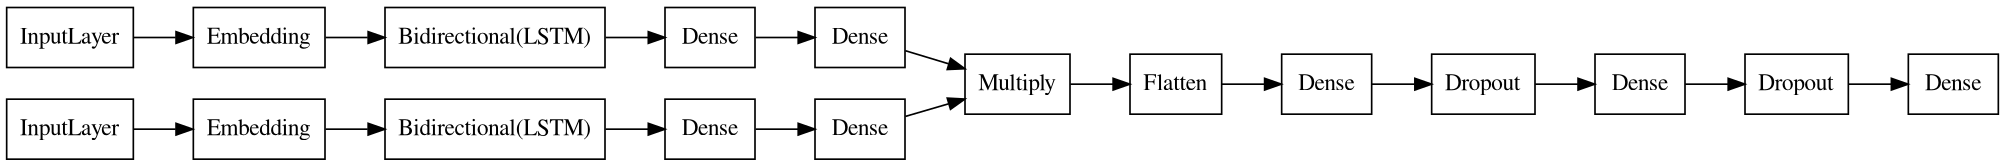

In [31]:
model = tuner.hypermodel.build(best_hps)
tf.keras.utils.plot_model(model, to_file='model.png', show_layer_names = False, dpi = 120, rankdir="LR")

In [32]:
history = model.fit([q1_train, q2_train], yTrain,
                    validation_data = ((q1_valid, q2_valid), yValid),
                    epochs = 20,
                    batch_size = 2048,
                    use_multiprocessing=True
)

Epoch 1/20
158/158 [==============================] - 23s 110ms/step - loss: 0.5514 - accuracy: 0.7138 - val_loss: 0.4890 - val_accuracy: 0.7608
Epoch 2/20
158/158 [==============================] - 16s 102ms/step - loss: 0.4624 - accuracy: 0.7779 - val_loss: 0.4628 - val_accuracy: 0.7750
Epoch 3/20
158/158 [==============================] - 16s 102ms/step - loss: 0.4096 - accuracy: 0.8054 - val_loss: 0.4600 - val_accuracy: 0.7828
Epoch 4/20
158/158 [==============================] - 16s 102ms/step - loss: 0.3576 - accuracy: 0.8304 - val_loss: 0.4673 - val_accuracy: 0.7843
Epoch 5/20
158/158 [==============================] - 16s 103ms/step - loss: 0.3048 - accuracy: 0.8580 - val_loss: 0.5235 - val_accuracy: 0.7856
Epoch 6/20
158/158 [==============================] - 16s 103ms/step - loss: 0.2580 - accuracy: 0.8823 - val_loss: 0.5562 - val_accuracy: 0.7841
Epoch 7/20
158/158 [==============================] - 16s 103ms/step - loss: 0.2202 - accuracy: 0.9015 - val_loss: 0.6480 - val_ac

#### Verlauf der Trainings- und Validationaccuracy

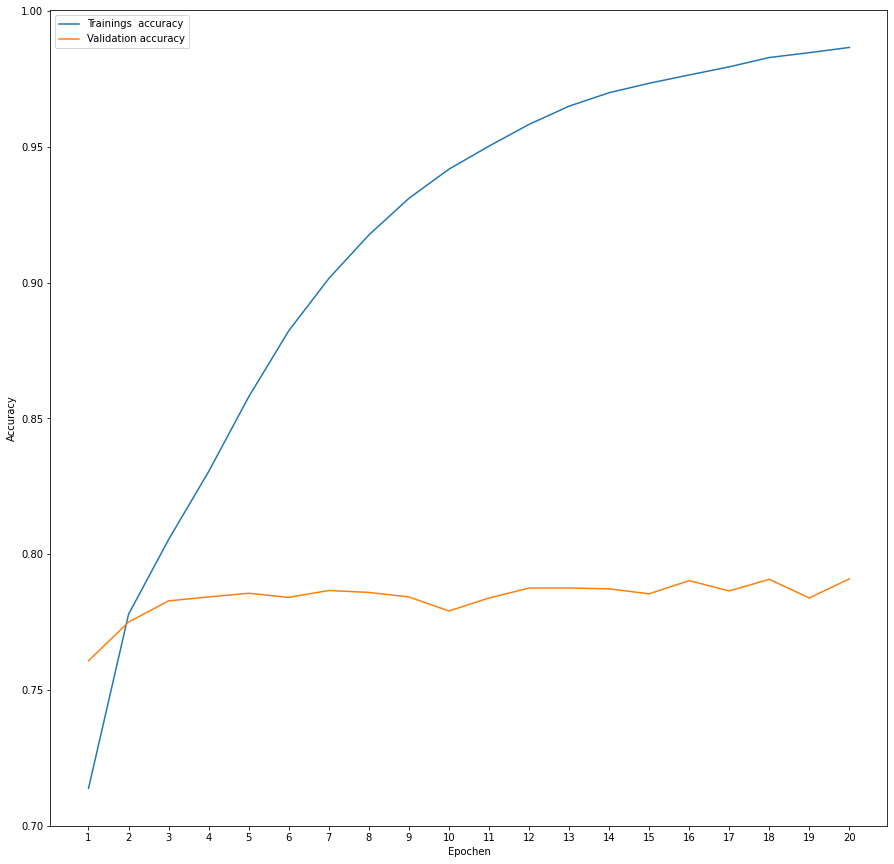

In [33]:
x = np.arange(1,21)

fig, ax = plt.subplots()
ax.plot(x, history.history['accuracy'], label="Trainings  accuracy")
ax.plot(x, history.history['val_accuracy'], label="Validation accuracy")
ax.legend()
ax.set_ylim(ymin=0.7)
ax.set_xticks(x)
ax.set_xlabel("Epochen")
ax.set_ylabel("Accuracy")
plt.show()

Wie sich aus dem Graph herauslesen lässt, ist zum Ende des Trainings des Modelles ein starkes Overfitting vorhanden.
Ab der zweiten Epoche übersteigt die Trainings-Accuracy die Validation-Accuracy.

Jedoch leidet die Validation-Accuracy nicht unter der Überanpassung.
Sie pendelt sich mit fortlaufenden Epochen auf einen konstanten Wert ein.

Trotzdem ist es sinnvoll, die Epochenanzahl mit der höchsten Validierungs-Accuracy zu extrahieren und das Modell mit der Anzahl dieser Epochen erneut zu trainieren.

Im folgenden Code-Abschnitt wird aus diesem Grund die ideale Anzahl der Epochen extrahiert.

In [34]:
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print(f"Optimale Anzahl der Epochen: {best_epoch}")

Optimale Anzahl der Epochen: 20


## Erneutes Bauen und Training des Modelles mit der optimalen Epochen-Anzahl

In [35]:
model = tuner.hypermodel.build(best_hps)
history = model.fit([q1_train, q2_train], yTrain,
                    validation_data = ((q1_valid, q2_valid), yValid),
                    epochs = best_epoch,
                    batch_size = 2048,
)

Epoch 1/20
158/158 [==============================] - 25s 121ms/step - loss: 0.5546 - accuracy: 0.7091 - val_loss: 0.4983 - val_accuracy: 0.7567
Epoch 2/20
158/158 [==============================] - 17s 105ms/step - loss: 0.4670 - accuracy: 0.7750 - val_loss: 0.4678 - val_accuracy: 0.7704
Epoch 3/20
158/158 [==============================] - 17s 105ms/step - loss: 0.4128 - accuracy: 0.8046 - val_loss: 0.4620 - val_accuracy: 0.7808
Epoch 4/20
158/158 [==============================] - 17s 105ms/step - loss: 0.3604 - accuracy: 0.8295 - val_loss: 0.4687 - val_accuracy: 0.7845
Epoch 5/20
158/158 [==============================] - 17s 110ms/step - loss: 0.3098 - accuracy: 0.8549 - val_loss: 0.5338 - val_accuracy: 0.7789
Epoch 6/20
158/158 [==============================] - 17s 107ms/step - loss: 0.2650 - accuracy: 0.8777 - val_loss: 0.5704 - val_accuracy: 0.7813
Epoch 7/20
158/158 [==============================] - 17s 108ms/step - loss: 0.2287 - accuracy: 0.8963 - val_loss: 0.6733 - val_ac

### Speicherung des Modelles
Nach dem Training erfolgt die Speicherung des gewonnenen Modelles.
Es erfolgt auch eine Speicherung des erstellten Dictionaries mit allen Fragen des Trainingsdatensets, sowie eine Speicherung des Tokenizers.

Diese Speicherung ist notwendig, um diese Komponenten bei der Erstellung der Applikation zur Vorhersage von Fragen zu nutzen.

In [36]:
import os
if not os.path.exists('models'):
    os.mkdir('models')

model.save('models/questions.h5')

np.save('models/questions.npy', completeQuestionsDict)

import json
tokenizer_json = tokenizer.to_json()
with open('models/tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

### Evaluation anhand der Genauigkeit des Modelels
In der folgenden Funktion wird die Genauigkeit des Modelles bestimmt.
Die Bestimmung der Genauigkeit erfolgt auf dem Trainingsdatenset, dem Validierungsdatenset und dem Testdatenset

In [37]:
trainings_eval = model.evaluate([q1_train, q2_train], yTrain, batch_size=2048)
print(f'Trainings acc: {trainings_eval[1]}')
valid_eval = model.evaluate([q1_valid, q2_valid], yValid, batch_size=2048)
print(f'Validation acc: {valid_eval[1]}')
test_results = model.evaluate([q1_test, q2_test], target_test, batch_size=2048)
print(f'Test acc : {test_results[1]}')

158/158 [==============================] - 4s 28ms/step - loss: 0.0278 - accuracy: 0.9908
Trainings acc: 0.9908016920089722
40/40 [==============================] - 1s 27ms/step - loss: 1.9626 - accuracy: 0.7829
Validation acc: 0.7829157114028931
1146/1146 [==============================] - 33s 29ms/step - loss: 18.4101 - accuracy: 0.2498
Test acc : 0.24976873397827148


Die Testaccuracy beträgt circa 98%, während die Validierungsaccuracy circa 79% beträgt.

Die Validierungsaccuracy mag zwar vergleichsweise niedrig sein.
Beim Vergleich eines Papers der "New York University" für ein nahezu identisches Problem ergaben sich jedoch vergleichbare Werte.[Referenz](https://arxiv.org/pdf/1907.01041.pdf)

Es fällt auf, dass bei der Evaluation des Modelles anhand der Testdaten eine sehr schlechte Accuracy erreicht wurde.
Dies mag auf ein schlechtes Modell zurückzuführen, welches jedoch entgegend der vergleichsweisen sehr guten Validation-Accuracy spricht.
Es mag zwar Unterschiede geben da die Validation-Accuracy ausschlaggebend beim Suchen der Hyperparameter war, jedoch ließe sich dadurch keine so hohe Abweichung erklären.

#### Evaluierung des Testdatensatzes
Bei der vorhergehenden Betrachtung des Testdatensets und seiner Label war auffällig, das sämtliche Fragepaarungen das Label 1 besitzen.
Bei der händischen Betrachtung der Fragenpaarungen des Testdatensatzes fällt jedoch auf, das viele Fragen keine oder nur eine sehr geringe sinnliche Ähnlichkeit besitzen.
Auch besitzen die Fragen teilweise eine sehr schlechte grammatikalische Qualität, was weiterhin zu Fehlklassifizierung führen kann.

Im folgenden finden sich Beispiele, bei denen die Klassifizierung mit dem Label 1 schlicht fehlerhaft ist.
```
58,"Why is glass a green in color?","What color say?"
122,"Is petroleum a mineral? If weight why?","Why mineral?"
129,"What is way?","What card good surrealism from bad surrealism?"
138,"Vit vs nirma?","Why do you create a blog?"
```
Bei anderen Fragepaarungen hängt die Klassifizierung mit dem Label 1 stark von der bewertenden Person ab.
So kann zwar bei der Fragepaarung `151,"How do I hide famous followers?","How can I the identity of a follower on Instagram?"` ein Zusammenhang in den Themen Instagram und Follower erkannt werden.
Jedoch mag der Sinn der Frage unterschiedlich sein, da es zum einem um das verstecken von berühmenten Followern und auf der anderen Seite um die Erkennung der Identität eines Followers geht.

Aus diesem Grund ist die Test-Accuracy mit Vorsicht zu betrachten
#### Auswertung der Klassifizierung
Stattdessen wurde sich dafür entschieden, eine reine Klassifizierung der Testdaten durchzuführen und diese entsprechend darzustellen.

Es wurde sich dazu entschieden, dass bei einem Duplication-Score von über 0.5 die entsprechende Fragepaarung mit dem Label 1 und damit als sinnlich verwandt einzustufen ist.

In [38]:
test = model.predict([q1_test, q2_test], batch_size = 2048, verbose = 1, use_multiprocessing = True)
test_labels = np.where(test > 0.5, 1, 0)
dist = np.unique(test_labels, return_counts=True)

1146/1146 [==============================] - 33s 27ms/step


In [39]:
print(f"Percentage of 0 labels in test-data: {dist[1][0] / len(test.flatten())}")
print(f"Percentage of 1 labels in test-data: {dist[1][1] / len(test.flatten())}")

Percentage of 0 labels in test-data: 0.7502312653732858
Percentage of 1 labels in test-data: 0.24976873462671423


Text(0.5, 1.0, 'Labels distribute from the prediction for the test-dataset')

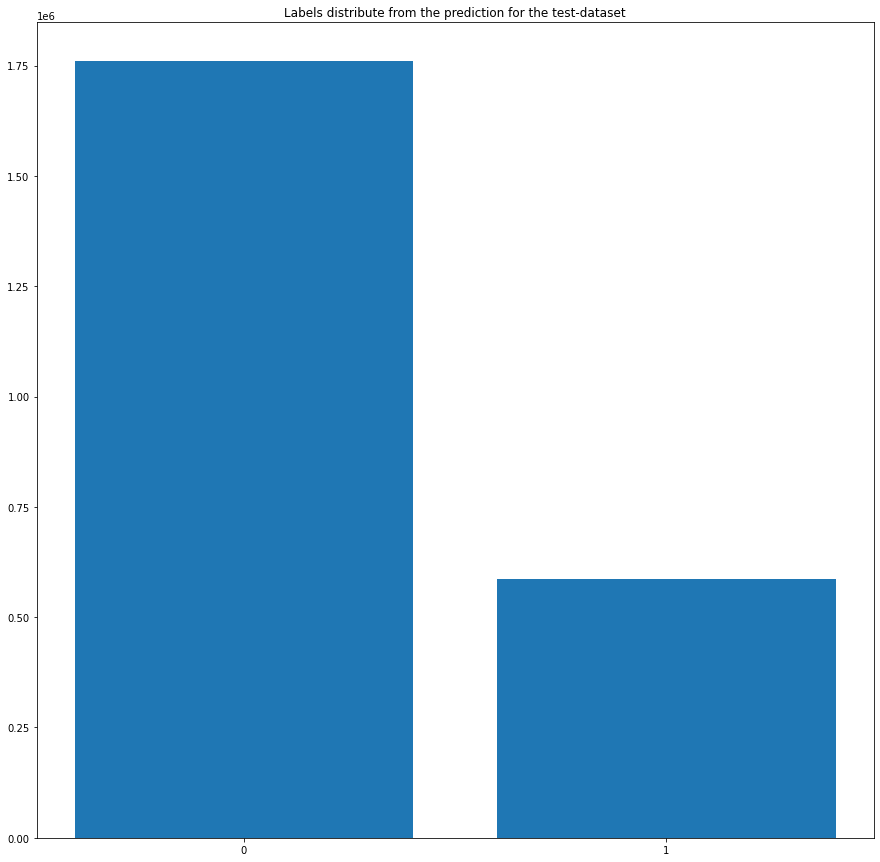

In [40]:
fig, ax = plt.subplots()

ax.bar([0,1],[dist[1][0], dist[1][1]])
ax.set_xticks([0,1], labels=[0,1])
ax.set_title('Labels distribute from the prediction for the test-dataset')

### Trainieren und Evaluierung des Modelles mit dem Trainingsdatensatz aufgeteilt in Trainigs-, Validierungs und Testdaten.
Um das trainierte Model besser bewerten zu können, wird im abschließend Code-Abschnitt das Model mit Testdaten, welche aus den Trainingsdaten abgespalten wurden, evaluiert.

Dabei wird das Model mit den ermittelten optimalen Parametern erstellt und anschließend mit den definierten Trainingsdaten trainiert. Dabei werden 20% der Trainingsdaten als Validierungsdaten benutzt.

Bei der anschließenden Evaluierung wird der Datensatz, welcher im vorherigen Model noch als Validierungsdaten benutzt wurde, als Testdatensatz verwendet.
Dieser entspricht damit 20% der eingelesenen Daten der Datei `train.csv`.

#### Erstellung und Training des Model

In [41]:
model = tuner.hypermodel.build(best_hps)
history = model.fit([q1_train, q2_train], yTrain,
                    validation_split=0.2,
                    epochs = best_epoch,
                    batch_size = 2048,
)

Epoch 1/20
127/127 [==============================] - 21s 119ms/step - loss: 0.5804 - accuracy: 0.6852 - val_loss: 0.5144 - val_accuracy: 0.7458
Epoch 2/20
127/127 [==============================] - 14s 107ms/step - loss: 0.4831 - accuracy: 0.7662 - val_loss: 0.4818 - val_accuracy: 0.7655
Epoch 3/20
127/127 [==============================] - 14s 107ms/step - loss: 0.4253 - accuracy: 0.7982 - val_loss: 0.4679 - val_accuracy: 0.7713
Epoch 4/20
127/127 [==============================] - 14s 108ms/step - loss: 0.3668 - accuracy: 0.8280 - val_loss: 0.4818 - val_accuracy: 0.7812
Epoch 5/20
127/127 [==============================] - 13s 106ms/step - loss: 0.3088 - accuracy: 0.8568 - val_loss: 0.5419 - val_accuracy: 0.7741
Epoch 6/20
127/127 [==============================] - 14s 106ms/step - loss: 0.2574 - accuracy: 0.8837 - val_loss: 0.5995 - val_accuracy: 0.7761
Epoch 7/20
127/127 [==============================] - 14s 108ms/step - loss: 0.2164 - accuracy: 0.9039 - val_loss: 0.6927 - val_ac

#### Evaluierung des Modelles

In [42]:
trainings_eval = model.evaluate([q1_train, q2_train], yTrain, batch_size=2048)
print(f'Trainings acc: {trainings_eval[1]}')
test_eval = model.evaluate([q1_valid, q2_valid], yValid, batch_size=2048)
print(f'Test acc: {test_eval[1]}')

158/158 [==============================] - 5s 30ms/step - loss: 0.4245 - accuracy: 0.9498
Trainings acc: 0.9497880339622498
40/40 [==============================] - 1s 29ms/step - loss: 1.9912 - accuracy: 0.7849
Test acc: 0.7848573923110962


Es ergibt sich, dass die Accuracy des Testdatensatzes ungefähr der Accuracy des Validierungsdatensatzes ähnelt.
#### Vorhersage Fragen des Testdatensatzes

In [43]:
test = model.predict([q1_test, q2_test], batch_size = 2048, verbose = 1, use_multiprocessing = True)
test_labels = np.where(test > 0.5, 1, 0)
dist = np.unique(test_labels, return_counts=True)

1146/1146 [==============================] - 32s 26ms/step


In [44]:
print(f"Percentage of 0 labels in test-data: {dist[1][0] / len(test.flatten())}")
print(f"Percentage of 1 labels in test-data: {dist[1][1] / len(test.flatten())}")

Percentage of 0 labels in test-data: 0.7608754406830961
Percentage of 1 labels in test-data: 0.2391245593169039


Text(0.5, 1.0, 'Labels distribute from the prediction for the test-dataset')

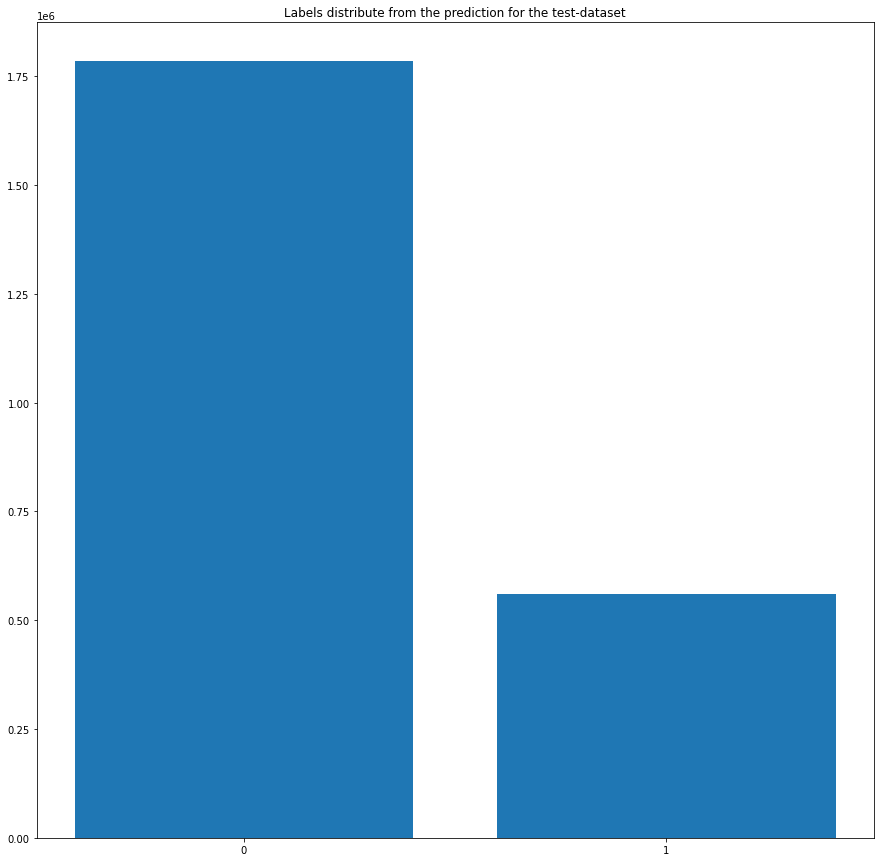

In [45]:
fig, ax = plt.subplots()

ax.bar([0,1],[dist[1][0], dist[1][1]])
ax.set_xticks([0,1], labels=[0,1])
ax.set_title('Labels distribute from the prediction for the test-dataset')


#### Bewertung der Ergebnisse des Modelles
Durch die Erstellung des Modelles und der Evalierung des Modelles mit eigens gewählten Testdaten lässt sich die Theorie der mangelhafen Testdaten aus `test.csv` bestätigen.

Es ist in der Tat davon auszugehen, das es sich bei der Kennzeichnung mit dem Label `1` für jede Fragenpaarung aus dem Testdatensatz um eine teilweise fehlerhafte Kennzeichnung handelt.
Deshalb gilt nach wie vor, dass die Evaluierung des Testdatensatzes aus `test.csv` mit Skepsis zu betrachten ist.
Die daraus gewonnene Accuracy ist daher nicht wirklich ausschlaggebend.

Die Accuracy für die Validierungs- und Testdaten beträgt circa 77%, während die Accuracy der Trainingsdaten sich deutlich über 90% befindet.
Dies deutet auf eine Überanpassung des Modelles hin.

## Implementierung in ein Frontend
Zur Implementierung einer entsprechenden Funktionalität wurde ein Flask-Backend erstellt.
Dieses bekommt vom Bentutzer, eine Frage übergeben, woraufhin es die 5 ähnlichsten Fragen ermittelt und dem Benutzer zurückgibt.

## Funktion zur Vorhersage der 5 am besten bewertesten Fragen
Im folgend erfolgt die Definition einer Funktion, welche ähnliche Fragen vorschlägt.
Dabei wird die Frage des Benutzers übergeben.

Anschließend wird für jede Frage aus dem gesammelten Fragenkatalog der Fragen aus `train.csv` der entsprechende "Übereinstimmungs"-Wert ermittelt.
Die 5 Fragen mit dem höchsten Wert werden durch den Tokenizer zurück in den entsprechenden String umgewandelt, und anschließend als Rückgabe der Funktion zurückgegeben.

In [46]:
model = tf.keras.models.load_model('models/questions.h5')
# Read the tokenizer
with open('models/tokenizer.json') as f:
    data = json.load(f)
    tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(data)
# Read the whole question catalog
completeQuestionsDict = np.load('models/questions.npy')

def getTopFiveQuestions(user_question):
    found_questions = []
    encoded_user_question = tokenizer.texts_to_sequences([user_question])
    encoded_user_question = pad_sequences(encoded_user_question, maxlen = 36, padding = 'post')
    completeUserQuestionArray = np.asarray([encoded_user_question[0]]*len(completeQuestionsDict))
    predictions = model.predict([completeUserQuestionArray, completeQuestionsDict], batch_size = 2048, verbose = 1, use_multiprocessing = True)
    predictions = predictions.flatten()
    ind = np.argpartition(predictions, -5)[-5:]
    for item in ind:
        decoded_question = tokenizer.sequences_to_texts([completeQuestionsDict[item]])[0]
        print(decoded_question)
        found_questions.append(decoded_question)
    return found_questions

Im folgenden wird die Funktion an der Frage 'What can make Physics easy to learn?' getestet.
Diese besitzt eine ähnliche Frage, welche auch im Trainings-Datensatz aufgeführt ist.
Außerdem wird die Zeit ermittelt, welche die Funktion zum Vorhersagen benötigt.

In [47]:
start = time.time()
foundQuestions = getTopFiveQuestions("What can make Physics easy to learn?")
end = time.time()
for i, question in enumerate(foundQuestions):
    print(f"Question {i}: {question}\n")
print(f"Benötigte Zeit: {end-start}")

262/262 [==============================] - 8s 25ms/step
what are the safety precautions on handling shotguns proposed by the nra in montana
how was chris wallace as a moderator in the presidential debate
what if space space part of spacetime was neither homogeneous nor isotropic
what is your review of fantastic beasts and where to find them movie
i'm planning to purchase a royal enfield bike since the vehicle seems to age nicely can anyone suggest which model to buy i will mostly use it for city commute and occasional long trips
Question 0: what are the safety precautions on handling shotguns proposed by the nra in montana

Question 1: how was chris wallace as a moderator in the presidential debate

Question 2: what if space space part of spacetime was neither homogeneous nor isotropic

Question 3: what is your review of fantastic beasts and where to find them movie

Question 4: i'm planning to purchase a royal enfield bike since the vehicle seems to age nicely can anyone suggest which

Aus den vorhergesagte Fragen lassen sich zwei Details analysieren.

Zum einem scheint es der Fall zu sein, dass je länger ein Frage ist, umso ähnlicher wird sie vom Model zur Ausgangsfrage klassifiziert.

Die spielt dann auch in den zweiten Fakt mit rein, dass die vorhergesagten Fragen subjektiv sinnlich nicht zur Ausgangsfrage passen.
Stattdessen wurden vorallem lange Fragen vorgeschlagen, welche eine anderen Sinn der Frage aufweisen.

Desweitern benötigt das Model zur Ermittelung der am sinnlich verwandesten Fragen mit der gegebenen Umgebung 6-7 Sekunden.
Dies ist für Echtzeitvorschläge, wie sie in der Aufgabenstellung gefordert waren, ein zu hoher Wert.
Der Benutzer würde Fragen vorgeschlagen bekommen, welche sinnlich noch weniger zu der nun erweiterten Benutzerfrage übereinstimmen.

Aus diesem Grunde wurde sich dafür entschieden, die Vorschläge nur auf expliziten Aufruf, sprich durch das Drücken eine entsprechenden Buttons durch den Benutzer, zu generieren.

### Gesamtlaufzeit

In [48]:
end_complete = time.time()
print(f"Gesamte Laufzeit des Trainings: {end_complete - start_complete}")

Gesamte Laufzeit des Trainings: 1628.7124691009521


Die Laufzeit mit der Evaluierung des optimalen Modelles durch den Hyperoptimizer beträgt circa 1.5h.
Bei einer erneuten Ausführung, während welcher die bereits erstellten Daten des Hyperoptimizers benutzt werden können, beträgt die Laufzeit ungefähr 15 Minuten.

## Fazit & Ausblick
Es wurde ein Machine-Learning Model erstellt, welches auf die Erkennung der sinnhaften Ähnlichkeit von zwei Fragen trainiert wurde.
Anhand einer anfänglichen Studien wurde sich für ein Klassifizierungsmodel entschieden, da ein "seq2seq"-Model zur Vorhersage ähnlicher Fragen eine deutlich geringere Accuracy erzielte.

Bei der Überprüfung der Accuracy des Modelles ergab sich dabei eine Validierungs-Accuracy von circa 78%.
Aufgrund mangelhafter Testdaten war eine Einschätzung des Modelles anhand der Testdaten nur wenig ausschlaggebend

Jedoch ergab sich, dass das Model vorallem zur Klassifizierung von zwei vorhandenen Fragen geeignet.
Zur Vorraussage von sinnlich ähnlich verwandten Fragen wurde eine Funktion erstellt, welche alle bekannten Fragen gegen eine Benutzereingabe vergleicht und die 3 am ähnlichsten Fragen zurückgibt.
Die daraus gewonnen Fragen wichen vom Sinn her jedoch stark von der Benutzerfrage ab.
Außerdem benötigt die Vorhersagen einen zeitlichen Aufwand von ungefähr 6-7 Sekunden.
Dies ist für eine Echtzeitvorhersage, wie sie in der Aufgabenstellung gefordert war, deutlich zu hoch.

Deshalb sollte bei weiterführunden Modellen dieses Laufzeit deutlich reduziert werden.
Sinnlich nicht verwandte Fragen sollten deutlich früher rausgefiltert werden, so dass keine Iteration über den kompletten Fragenkatalog notwendig ist.
Außerdem könnte in Betracht gezogen werden, ob ein Model zur Vervollständigung der bisherigen Benutzereingabe unter Umständen genauere Vorschläge erzeugen kann.
Dazu könnten auch die in diesem Modell gewonnenen Informationen in Betracht gezogen werden können.

Unter der Vorsatz, dass die Laufzeit deutlich verringert zur Vorhersage deutlich verringert wird, wäre auch eine Echtzeitvorhersage von ähnlichen Fragen möglich.

Eine weitere Möglichkeit, welche aufgrund des zeitlichen Rahmens nicht weiter erforscht wurde, stellt die Implementierung eines Bag-of-Words-Modell dar.
Ein solches Modell könnte den Kontext der bisherigen Eingabe evaluieren, und anschließend mit den bestehenden Daten eine entsprechende Vorhersage generieren.

In der Vorverarbeitung wäre anstatt eines Tokenizer die Verwendungen eines BERT von Vorteilen gewesen.
So erzielte dieser in Modellen mit einer vergleichbaren Aufgabenstellung bei den Validierungsdaten eine Accuracy von circa 90%.[Referenz](https://huggingface.co/gchhablani/bert-base-cased-finetuned-qqp)